### Loading gene selection criteria

In [1]:
import pandas as pd

def load_criteria(criteria_input):
    print(" [i] Loading criteria...")
    # Load in the wanted gene symbol and corresponding Ensembl number 
    criteria = pd.read_csv(criteria_input)

    # Remove rows where "converted_alias" is "None"
    criteria = criteria[criteria["converted_alias"] != "None"]

    # Remove duplicates and keep the first one
    criteria = criteria.drop_duplicates(subset = "initial_alias", keep = "first")

    # Generate Ensembl_ID list
    num_list = criteria["converted_alias"]

    # In the list, remove the duplicates by list(set()) method
    num_list = list(set(num_list))

    # Return "num_list" for further use
    return num_list
    

### Loading gene expression data in parquet file

In [2]:
import polars as pl

def load_parquet(parquet_input, criteria_input):
    print(" [i] Loading original gene expression data...")
    # Read the full parquet file with lazy loading
    df = pl.read_parquet(parquet_input).lazy()

    # Select f64 columns and convert them to f32 to save memory
    schema = df.collect_schema()
    convert = [
        pl.col(name).cast(pl.Float32).alias(name)
        if dtype == pl.Float64 else pl.col(name)
        for name, dtype in schema.items()
    ]

    # Apply the convertion to dataframe w/o materializing
    converted = df.select(convert)

    # In "convered" dataframe, apply the criteria
    num_list = load_criteria(criteria_input)
    converted = converted.select(num_list)

    # Read the full dataframe
    df = converted.collect()

    # Drop the last column
    df = df.drop(df.columns[-1])

    return df

### Loading metadata in csv file

In [3]:
import pandas as pd
import csv

def load_metadata(csv_input):
    print(" [i] Loading metadata...")
    metadata_df = pd.read_csv(csv_input, delimiter = ",", quoting = csv.QUOTE_ALL, escapechar = "\\")

    return metadata_df

### Combining the original data with metadata

In [4]:
import polars as pl
import pandas as pd

def combine(df, metadata_df):
    print(" [i] Combining original data with metadata...")
    metadata_df = pl.from_pandas(metadata_df)
    final_df = pl.concat([df, metadata_df], how = "horizontal")

    return final_df

### XGBoost’s own feature importance ranking

In [5]:
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

def feature_ranking(final_df, criteria_input, output_dir):
    print(" [i] Starting XGBoost analysis...")
    # Call in the dataframe
    df = final_df

    # Prepare the transformation method
    le = LabelEncoder()

    # Separate feature and target columns
    X = final_df.drop("cancer_type")
    y = df["cancer_type"]
    
    # Transform the label to integer using "le" method
    y = le.fit_transform(y)

    print(" [i] Splitting training and validation data...")
    # Split the training and validation data
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size = 0.2, random_state = 42)

    print(" [i] Building XGBoost model...")
    # Build XGBoost model
    model = xgb.XGBClassifier(
        objective = "multi:softprob",
        max_depth = 3,
        learning_rate = 0.1,
        n_estimators = 100,
        random_state = 42
    )

    print(" [i] Training XGBoost model...")
    # Training XGBoost model
    model.fit(
        X_train, y_train,
        eval_set = [(X_train, y_train), (X_valid, y_valid)],
        verbose = True
    )

    # Prediction and evaluation
    y_pred = model.predict(X_test)
    y_test_labels = le.inverse_transform(y_test)
    y_pred_labels = le.inverse_transform(y_pred)

    # Print the accuracy and classification report
    print(f" [!] XGBoost Accuracy: {round(accuracy_score(y_test_labels, y_pred_labels), 2)}.")
    print(f" [!] Classification report: \n, {classification_report(y_test_labels, y_pred_labels)}")

    # Result variable
    print(f" [i] Generating results...")
    result = model.evals_result()

    # Extract the value of feature importance from the model
    feature_importance = model.feature_importances_
    
    # Sort the corresponding gene according to the ranking
    convert = pd.read_csv(criteria_input)
    num_list_new = X.columns

    print(f" [i] Ranking the importance of features (Genes)...")
    importance_df = pd.DataFrame({"Gene": num_list_new, "Importance": feature_importance})
    importance_df = importance_df.sort_values(by = "Importance", ascending = False)

    # Transform Ensembl IDs to gene symbols
    print(f" [i] Converting Ensembl IDs to gene symbols...")
    
    convert_df = dict(zip(convert["converted_alias"], convert["name"]))
    importance_df["Gene_symbol"] = importance_df["Gene"].map(convert_df)

    # Debug: Check for any missing values
    missing = importance_df[importance_df["Gene_symbol"].isna()]
    if not missing.empty:
        print(f" [!] {len(missing)} missing names detected.")

    # Save the ranked feature importance as .csv file
    os.makedirs(output_dir, exist_ok = True)
    importance_df.to_csv(os.path.join(output_dir, "XGBoost_feature_importance.csv"), index = False)

    # Feedback message
    print(f" [i] Feature importance is saved in directory: {output_dir}")

    # Return the result
    return X, y, le, model, result


### Drawing the learning curve

In [6]:
import matplotlib.pyplot as plt
import os

def draw_learning_curves(result, output_dir):
    print(f" [i] Drawing learning curves...")
    # Read in the data to draw the plot
    epochs_0 = result["validation_0"]["mlogloss"]
    epochs_1 = result["validation_1"]["mlogloss"]
    epochs = len(result["validation_0"]["mlogloss"])
    x_axis = range(epochs)

    # Draw the plot using matplotlib
    plt.figure(figsize = (9.6, 5.4))
    plt.plot(x_axis, epochs_0, label = 'Train mlogloss')
    plt.plot(x_axis, epochs_1, label = 'Validation mlogloss')

    # Add title and label the two axies to the plot
    plt.title("XGBoost Log Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log Loss")
    plt.legend()

    # Add grid lines
    plt.grid(True)

    # Adjust the elements in the plot to avoid overlapping
    plt.tight_layout()

    # Show the plot to ensure the correctness
    # plt.show()

    # Save the plot in specific directory
    os.makedirs(output_dir, exist_ok = True)
    plt.savefig(os.path.join(output_dir, "XGBoost_learning_curves.png"))

    # Print the feedback message
    print(f" [i] Learning curve is saved in directory: {output_dir}.")


### 5-fold cross-validation

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import cross_val_score

def cross_validation(model, X, y, output_dir):
    print(f" [i] Doing cross-validation...")
    # Calculate the scores
    scores = cross_val_score(model, X, y, cv = 5, scoring = "accuracy")

    # Draw the plot for cross validation
    plt.figure(figsize = (9.6, 5.4))
    sns.barplot(x = list(range(1, 6)), y = scores)
    plt.axhline(y = scores.mean(), color = "r", linestyle = '--',
                label = f"Mean Accuracy: {round(scores.mean(), 2)}")
    plt.ylim(0, 1)

    # Add title and label the two axies to the plot
    plt.xlabel("Fold")
    plt.ylabel("Accuracy")
    plt.title("5-Fold Cross Validation Accuracy")
    plt.legend()

    # Show the plot to ensure the correctness
    # plt.show()

    # Save the plot in specific directory
    os.makedirs(output_dir, exist_ok = True)
    plt.savefig(os.path.join(output_dir, "XGBoost_cross_validation.png"))

    # Print the feedback message
    print(f" [i] Cross-validation is saved in directory: {output_dir}.")



### Confusion Matrix determining

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix

def confusion_matrix_determining(model, X, y, le, output_dir):
    print(f" [i] Determining confusion matrix...")
    # Determining cv value using StratifiedKFold (?)
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    
    # Determining confusion matrix
    y_pred_cv = cross_val_predict(model, X, y, cv = cv)
    cm = confusion_matrix(y, y_pred_cv)

    # Drawing the plot for confusion matrix
    plt.figure(figsize = (9.6, 5.4))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues",
                xticklabels = le.classes_, yticklabels = le.classes_)
    
    # Add title and label the two axies to the plot
    plt.title("Confusion Matrix -- 5-Fold Cross Validation")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Show the plot to ensure the correctness
    # plt.show()

    # Save the plot in specific directory
    os.makedirs(output_dir, exist_ok = True)
    plt.savefig(os.path.join(output_dir, "XGBoost_confusion_matrix.png"))

    # Print the feedback message
    print(f" [i] Confusion matrix is saved in directory: {output_dir}.")
    

### Main Process

 [i] Loading criteria...
 [i] Loading original gene expression data...
 [i] Loading criteria...
 [i] Loading metadata...
 [i] Combining original data with metadata...
 [i] Starting XGBoost analysis...
 [i] Splitting training and validation data...
 [i] Building XGBoost model...
 [i] Training XGBoost model...
[0]	validation_0-mlogloss:2.76430	validation_1-mlogloss:2.80839
[1]	validation_0-mlogloss:2.44267	validation_1-mlogloss:2.50979
[2]	validation_0-mlogloss:2.20913	validation_1-mlogloss:2.29454
[3]	validation_0-mlogloss:2.02303	validation_1-mlogloss:2.12464
[4]	validation_0-mlogloss:1.87041	validation_1-mlogloss:1.98475
[5]	validation_0-mlogloss:1.74037	validation_1-mlogloss:1.86388
[6]	validation_0-mlogloss:1.62634	validation_1-mlogloss:1.75869
[7]	validation_0-mlogloss:1.52631	validation_1-mlogloss:1.66575
[8]	validation_0-mlogloss:1.43723	validation_1-mlogloss:1.58606
[9]	validation_0-mlogloss:1.35682	validation_1-mlogloss:1.51264
[10]	validation_0-mlogloss:1.28290	validation_1-ml

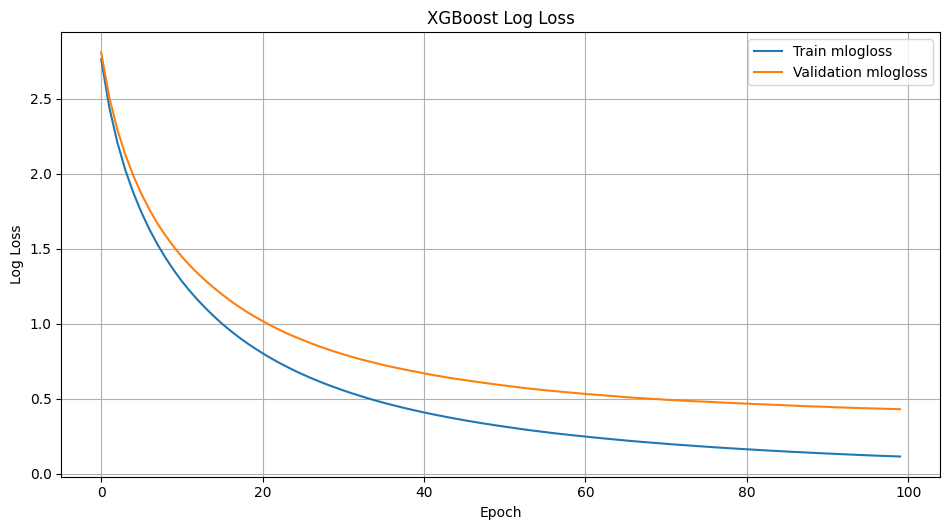

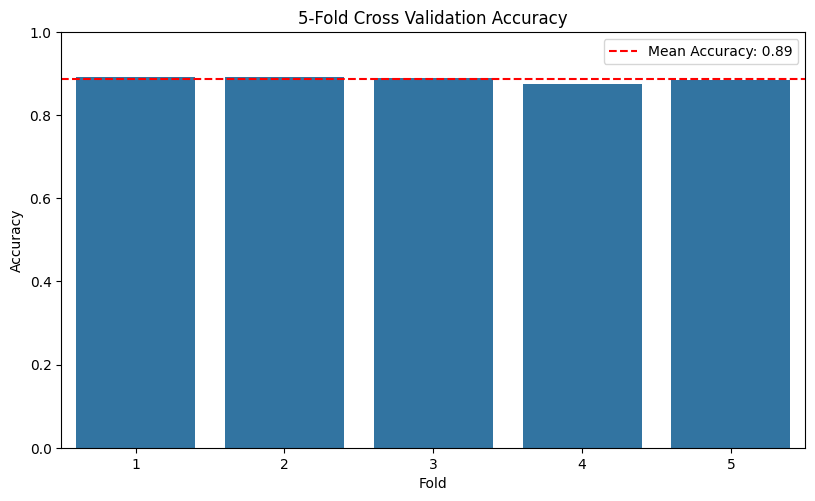

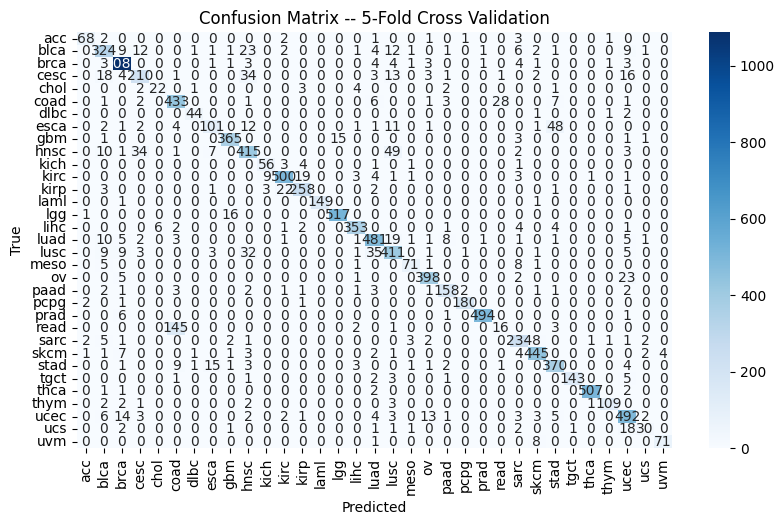

In [ ]:
if __name__ == "__main__":
    # Start time record
    import time
    start = time.time()

    # File path definition
    parquet_input = r"/home/terry-liu/桌面/xgboost/data/df_matched.parquet"
    csv_input = r"/home/terry-liu/桌面/xgboost/data/metadata_matched.csv"
    criteria_input = r"/home/terry-liu/桌面/xgboost/data/CRC_mutations_new.csv"
    
    # Output file directory definition
    output_dir = r"/home/terry-liu/桌面/XGBoost_output"

    # Forming dataframe for analysis and plotting
    num_list = load_criteria(criteria_input)
    df = load_parquet(parquet_input, criteria_input)
    metadata_df = load_metadata(csv_input)
    final_df = combine(df, metadata_df)

    # Feature ranking
    X, y, le, model, result = feature_ranking(final_df, criteria_input, output_dir)

    # Drawing learning curves
    draw_learning_curves(result, output_dir)

    # Drawing 5-fold cross-validation
    cross_validation(model, X, y, output_dir)
    
    # Determining confusion matrix
    confusion_matrix_determining(model, X, y, le, output_dir)

    # End time record
    end = time.time()
    elapsed_time = int(end - start)
    hours = elapsed_time // 3600
    minutes = elapsed_time % 3600 // 60
    seconds = elapsed_time % 60

    print(f" [i] Time spent: {hours} hours, {minutes} minutes and {seconds} seconds.")